# Прогнозирование параметров сварного шва при электронно-лучевой сварке в глубоком вакууме

## Импорт библиотек

In [47]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
import sklearn
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Normalization, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError

%matplotlib inline

In [3]:
# Отключаем предупреждения
warnings.filterwarnings('ignore')

## 1. Текстовое описание набора данных

В качестве набора данных мы будем использовать набор данных по результатам металлографического контроля по размеров сварочного шва при электронно-лучевой сварке в глубоком вакууме.

Файл датасета:

- ebw_data.csv

Файл датсета имеет следующие колонки:

- IW - величина сварочного тока 
- IF - ток фокусировки электронного пучка 
- VW - скорость сварки 
- FP - расстояние от поверхности образцов до электронно-оптической системы
- Depth - глубина шва 
- Width - ширина шва

Целевые признаки при прогнозировании:

- Depth - глубина шва 
- Width - ширина шва

## 2. Описательный анализ данных

### 2.1. Основные характеристики датасета

In [4]:
# Путь к CSV файлу с данными
path = 'data/ebw_data.csv'

In [5]:
# Загружаем файл с данными в датасет с помощью библиотеки Pandas
dataset = pd.read_csv(path)

In [6]:
# Выводим первые 5 строк датасета
dataset.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


In [7]:
# Сводная информация о датасете
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


In [8]:
# Основные статистические характеристки датасета
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
IW,72.0,45.666667,1.678363,43.00,44.00,45.50,47.00,49.00
IF,72.0,141.333333,5.145763,131.00,139.00,141.00,146.00,150.00
VW,72.0,8.638889,2.061078,4.50,8.00,9.00,10.00,12.00
FP,72.0,78.333333,21.493530,50.00,60.00,80.00,80.00,125.00
Depth,72.0,1.195556,0.225081,0.80,1.08,1.20,1.29,1.76
Width,72.0,1.970417,0.279040,1.68,1.76,1.84,2.05,2.60


In [9]:
# Проверим наличие пустых значений
dataset.isna().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

## 3. Визуальное исследование датасета

### 3.1. Построение Boxplot

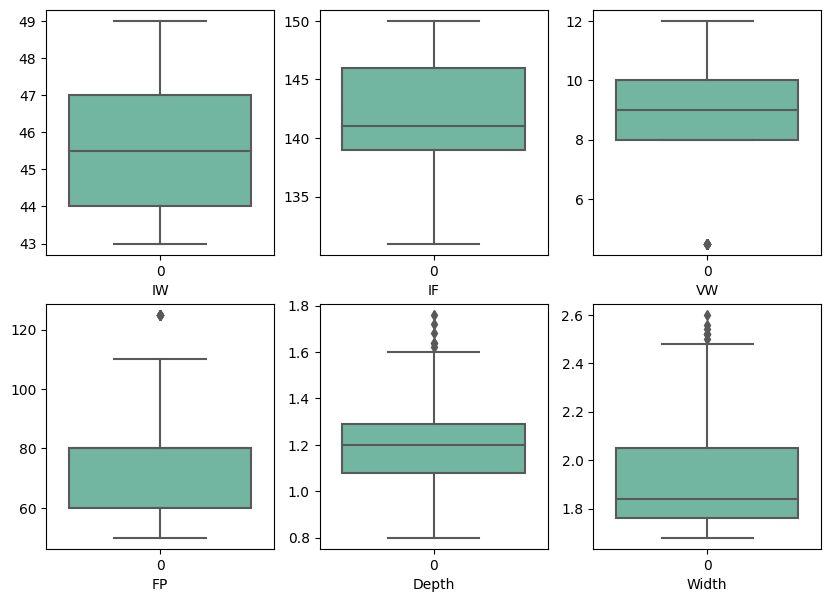

In [10]:
plt.figure(figsize=(10, 7))
plt.subplot(231)
plt.xlabel('IW')
sns.boxplot(data=dataset['IW'], palette='Set2')
plt.subplot(232)
plt.xlabel('IF')
sns.boxplot(data=dataset['IF'], palette='Set2')
plt.subplot(233)
plt.xlabel('VW')
sns.boxplot(data=dataset['VW'], palette='Set2')
plt.subplot(234)
plt.xlabel('FP')
sns.boxplot(data=dataset['FP'], palette='Set2')
plt.subplot(235)
plt.xlabel('Depth')
sns.boxplot(data=dataset['Depth'], palette='Set2')
plt.subplot(236)
plt.xlabel('Width')
sns.boxplot(data=dataset['Width'], palette='Set2')
plt.show()

Выбросы в данных присутствуют, но ввиду небольшого размера датасета, пренебрегаем ими

### 3.2. Построение парных диаграмм

<Figure size 900x900 with 0 Axes>

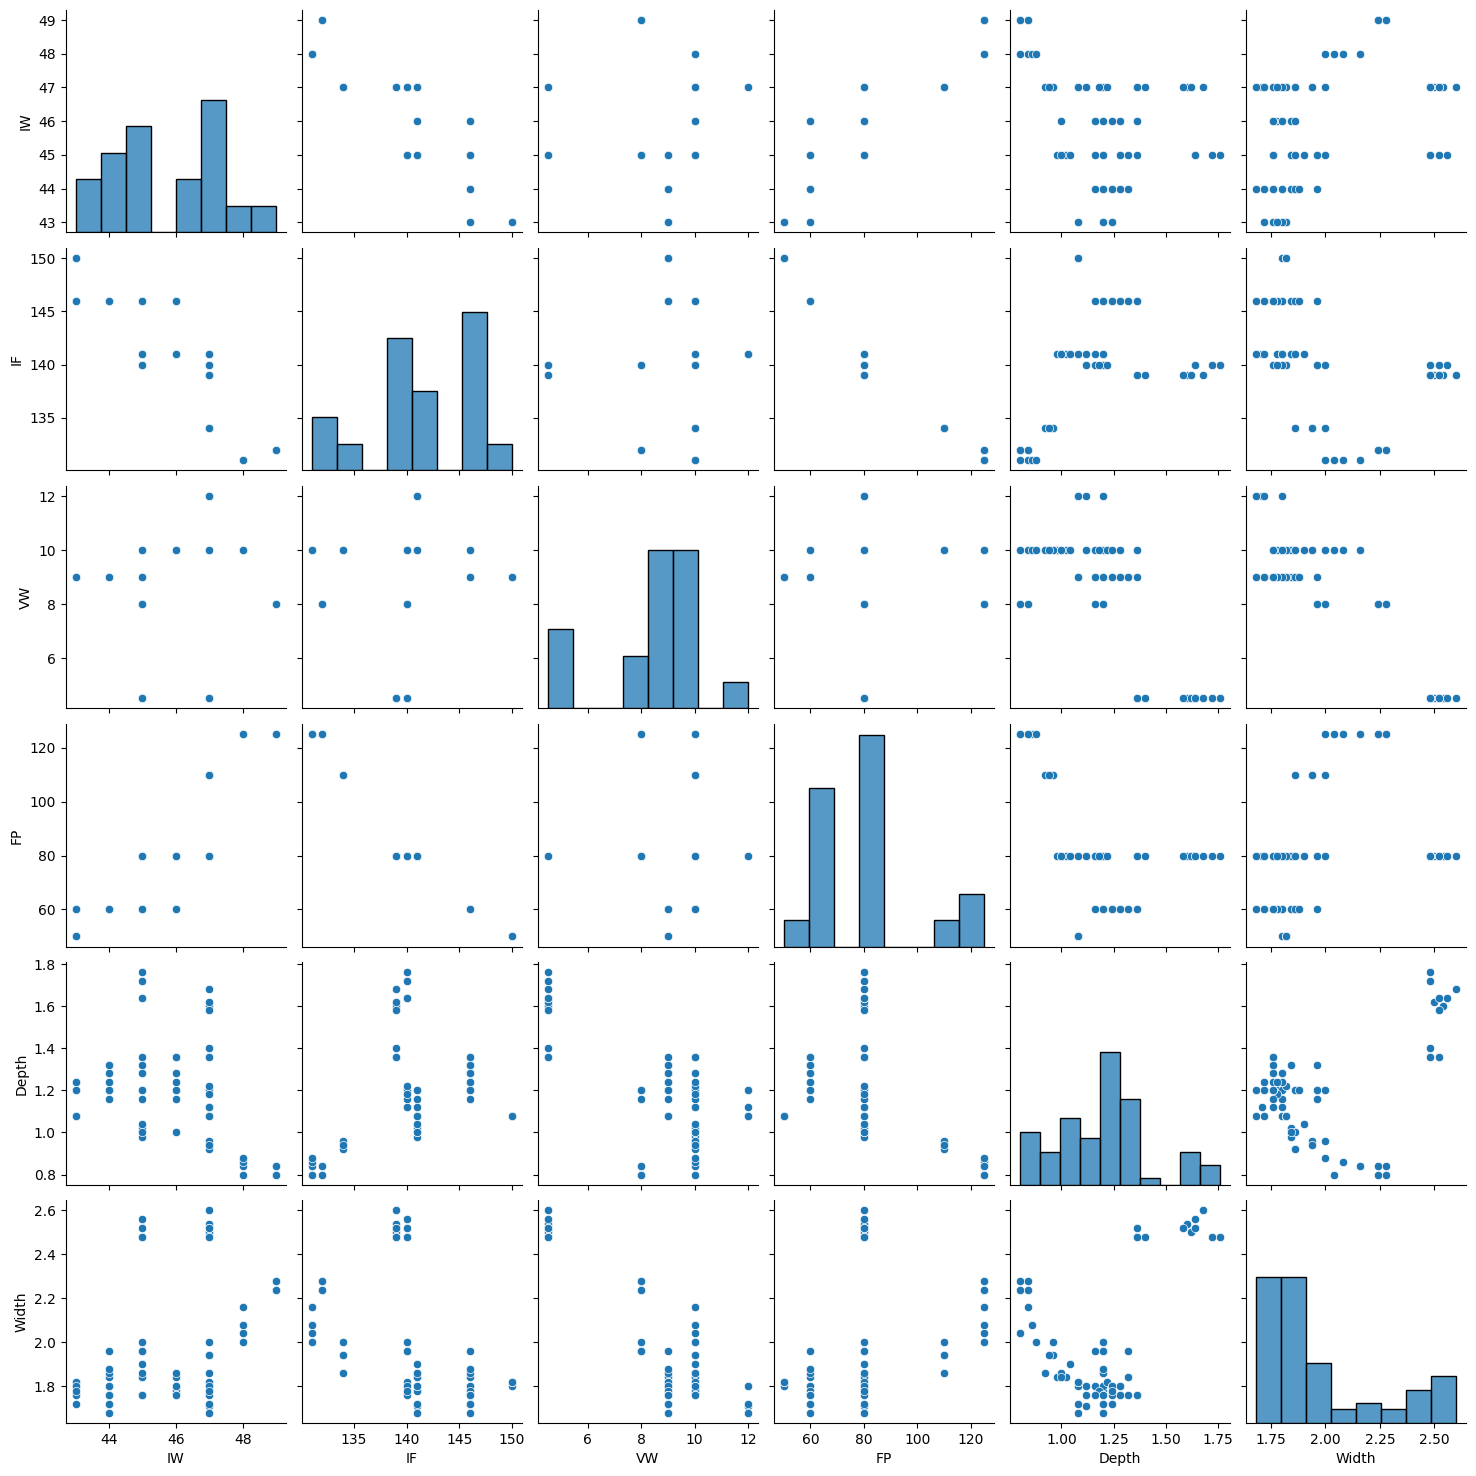

In [11]:
plt.figure(figsize=(9, 9))
sns.pairplot(dataset)
plt.show()

### 3.3. Информация о корреляции признаков

In [12]:
# Корреляционная матрица для датасета
dataset.corr()

,IW,IF,VW,FP,Depth,Width
IW,1.000000,-0.861073,-0.043430,0.835530,-0.289568,0.434869
IF,-0.861073,1.000000,0.115093,-0.980562,0.376084,-0.510167
VW,-0.043430,0.115093,1.000000,-0.001060,-0.671437,-0.874257
FP,0.835530,-0.980562,-0.001060,1.000000,-0.510748,0.412962
Depth,-0.289568,0.376084,-0.671437,-0.510748,1.000000,0.425391
Width,0.434869,-0.510167,-0.874257,0.412962,0.425391,1.000000


<AxesSubplot: >

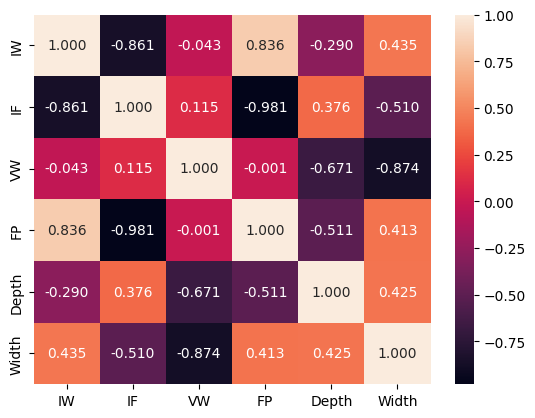

In [13]:
# Корреляуионая матрица в визуальном представлении
sns.heatmap(dataset.corr(), annot=True, fmt='.3f')

В датасете пристуствуют признаки, которые в значительной степени коррелируют друг с другом, но ввиду небольшого размера датасета и всаимосвязи признаков согласно технологии рассматриваемого процесса, пренебрегаем ими.

## 4. Выбор наиболее подходящей модели для решения задачи регрессии

### 4.1. Регрессионные модели Scikit-Learn

Для дальнейшего исследования были выбраны следующие модели:

- GradientBoostingRegressor
- RandomForestRegressor
- LinearRegression
- DecisionTreeRegressor
- Ridge

### 4.2. Построение базового решения для выбранных моделей без подбора гиперпараметров

In [14]:
# Скопируем исходный датасет для решения промежуточной задачи
dataset_select_model = dataset.copy()

# Выделим признаки
X_select_model = np.array(dataset_select_model.iloc[:,0:4])

# Выделим целевые переменные Depth и Width по отдельности
y_depth_select_model = np.array(dataset_select_model['Depth'])
y_width_select_model = np.array(dataset_select_model['Width'])

# Определим для удобства список целевых перемнных
targets = [y_depth_select_model, y_width_select_model]

# Определим список регрессионных моделей, которые будет использовать для построения базового решения
models = {'GBR': GradientBoostingRegressor(), 
          'RFR': RandomForestRegressor(),
          'LR': LinearRegression(),
          'DTR': DecisionTreeRegressor(),
          'R': Ridge()}

# Определим список разбивок для разных целевых переменных
splits = [train_test_split(X_select_model, targets[0], test_size=0.2, random_state=42),
          train_test_split(X_select_model, targets[1], test_size=0.2, random_state=42)]

# Определим словари для хранения значений метрик R2, MAE, MSE регрессионных моделей
r2_depth = {}
r2_width = {}
mae_depth = {}
mae_width = {}
mse_depth = {}
mse_width = {}


def select_model():
    # Функция для построения базовых решений регрессионных моделей
    
    # Перебираем модели
    for model_name, model in models.items():
        
        # Определим списки метрик для разных целевых переменных
        r2_scores = []
        mae_scores = []
        mse_scores = []
                    
        # Перебираем разбивки для разных целевых переменных
        for split in splits:

            # Разбивка
            X_train, X_test, y_train, y_test = split

            # Обучаем модель и делаем предсказания
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Считаем метрики модели для целевой переменной
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)

            # Добавляем значения метрик в списки
            r2_scores.append(r2)
            mae_scores.append(mae)
            mse_scores.append(mse)

        # Заполняем словари метрик
        r2_depth[model_name] = round(r2_scores[0], 3)
        r2_width[model_name] = round(r2_scores[1], 3)
        mae_depth[model_name] = round(mae_scores[0], 3)
        mae_width[model_name] = round(mae_scores[1], 3)
        mse_depth[model_name] = round(mse_scores[0], 3)
        mse_width[model_name] = round(mse_scores[1], 3)

In [15]:
# Выполним функцию для построения базовых решений регрессионных моделей
select_model()

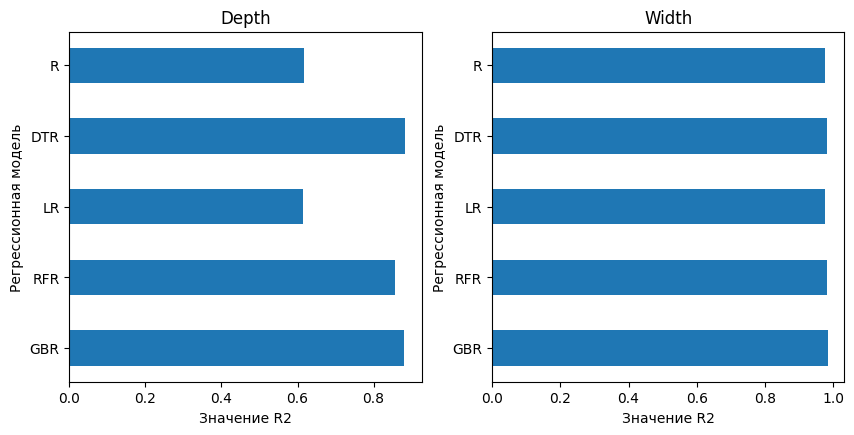

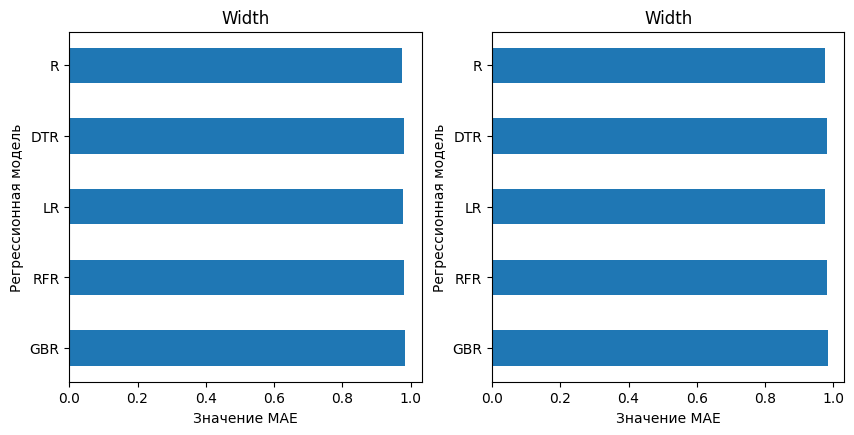

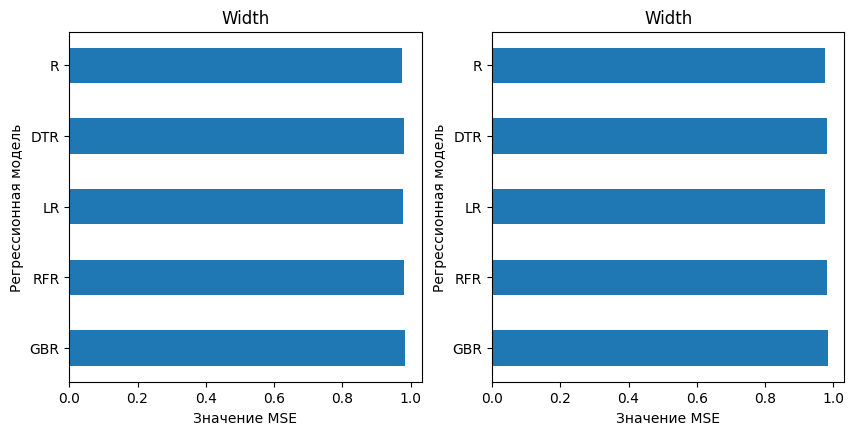

In [16]:
# Строим графики для визуализации полученных мерик для базовых решений

# Строим графики метрики R2 для целевых переменных Depth и Width
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.barh(list(r2_depth.keys()), list(r2_depth.values()), align='center', height=0.5)
plt.xlabel("Значение R2")
plt.ylabel("Регрессионная модель")
plt.title("Depth")
plt.subplot(222)
plt.barh(list(r2_width.keys()), list(r2_width.values()), align='center', height=0.5)
plt.xlabel("Значение R2")
plt.ylabel("Регрессионная модель")
plt.title("Width")
plt.show()

# Строим графики метрики MAE для целевых переменных Depth и Width
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.barh(list(r2_width.keys()), list(r2_width.values()), align='center', height=0.5)
plt.xlabel("Значение MAE")
plt.ylabel("Регрессионная модель")
plt.title("Width")
plt.subplot(222)
plt.barh(list(r2_width.keys()), list(r2_width.values()), align='center', height=0.5)
plt.xlabel("Значение MAE")
plt.ylabel("Регрессионная модель")
plt.title("Width")
plt.show()

# Строим графики метрики MSE для целевых переменных Depth и Width
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.barh(list(r2_width.keys()), list(r2_width.values()), align='center', height=0.5)
plt.xlabel("Значение MSE")
plt.ylabel("Регрессионная модель")
plt.title("Width")
plt.subplot(222)
plt.barh(list(r2_width.keys()), list(r2_width.values()), align='center', height=0.5)
plt.xlabel("Значение MSE")
plt.ylabel("Регрессионная модель")
plt.title("Width")
plt.show()

In [17]:
# Выводим значение метрики R2 для целевой переменной Depth
D_R2 = pd.DataFrame(r2_depth, index=['R2(Depth)']).T
D_R2.sort_values(by='R2(Depth)')

,R2(Depth)
LR,0.615
R,0.617
RFR,0.855
GBR,0.881
DTR,0.882


In [18]:
# Выводим значение метрики R2 для целевой переменной Width
W_R2 = pd.DataFrame(r2_width, index=['R2(Width)']).T
W_R2.sort_values(by='R2(Width)')

,R2(Width)
R,0.976
LR,0.977
RFR,0.982
DTR,0.982
GBR,0.983


#### 4.2.1. Промежуточный вывод

По результатам построения базовых решений для регрессионных моделей можно сделать вывод, что для решения поставленной задачи можно применять модели: GradientBoostingRegressor, DecisionTreeRegressor. Эти модели дают примерно один результат для целевых переменных при одинаковом значении метрик MAE и MSE.

### 4.3. Проектирование искусственной нейронной сети

In [19]:
# Делаем копию исходного датасета
dataset_nn = dataset.copy()

# Формируем датасет для целевой переменной Depth
dataset_d = pd.DataFrame(dataset_nn[['IW', 'IF', 'VW', 'FP', 'Depth']])
# Формируем датасет для целевой переменной Width
dataset_w = pd.DataFrame(dataset_nn[['IW', 'IF', 'VW', 'FP', 'Width']])

In [20]:
# Разаобьем датасет для целевой переменной Depth на обучающую и тестовую выборку
train_dataset_d = dataset_d.sample(frac=0.8, random_state=42)
test_dataset_d = dataset_d.drop(train_dataset_d.index)

# Разаобьем датасет для целевой переменной Width на обучающую и тестовую выборку
train_dataset_w = dataset_w.sample(frac=0.8, random_state=42)
test_dataset_w = dataset_w.drop(train_dataset_w.index)

In [21]:
# Определим признаки и метки для целевой переменной Depth
train_features_d = train_dataset_d.copy()
test_features_d = test_dataset_d.copy()
train_labels_d = train_features_d.pop('Depth')
test_labels_d = test_features_d.pop('Depth')

# Определим признаки и метки для целевой переменной Width
train_features_w = train_dataset_w.copy()
test_features_w = test_dataset_w.copy()
train_labels_w = train_features_w.pop('Width')
test_labels_w = test_features_w.pop('Width')

#### 4.3.1. Искусственная нейорнная сеть для прогнозирования целевой переменной Depth

In [22]:
# Нормализуем признаки обучающей выборки
normalizer = Normalization(axis=-1)
normalizer.adapt(np.array(train_features_d))

In [23]:
# Строим модель нейронной сети
model_d = keras.Sequential([
    normalizer,
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

In [24]:
# Компилируем модель
model_d.compile(
    optimizer=Adam(0.001),
    loss='mean_absolute_error'
)

In [25]:
# Обучаем нейронную сеть
history = model_d.fit(
    train_features_d,
    train_labels_d,
    epochs=500,
    verbose=0,
    validation_split=0.2
)

In [26]:
# Функция для визуализации процесса обучения нейронной сети
def plot_loss(history):
    
    plt.plot(history.history['loss'], label='Ошибка на обучающей выборке')
    plt.plot(history.history['val_loss'], label='Ошибка на валидационной выборке')
    plt.ylim([0, 1])
    plt.xlabel('Эпохи обучения')
    plt.ylabel('Значение ошибки')
    plt.legend()
    plt.grid(True)

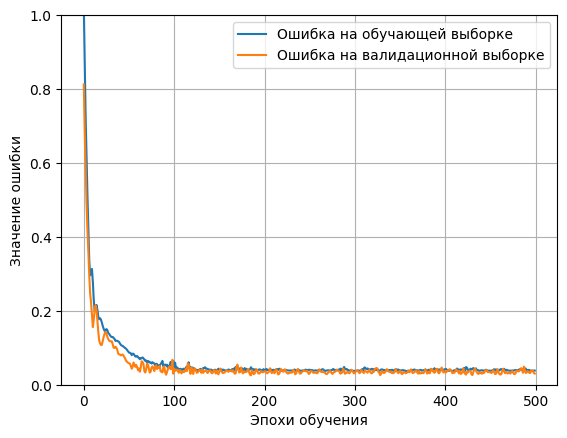

In [27]:
# Строим график обучения
plot_loss(history)

In [28]:
# Делаем предсказания на тестовой выборке
y_pred_d = model_d.predict(test_features_d)

1/1 [==============================] - 0s 69ms/step


In [29]:
# Оцениваем метрику R2
r2_d = r2_score(test_labels_d, y_pred_d)
# Оцениваем метрику MAE
MAE = MeanAbsoluteError()
mae_d = MAE(test_labels_d, y_pred_d).numpy()
# Оцениваем метрику MSE
MSE = MeanSquaredError()
mse_d = MSE(test_labels_d, y_pred_d).numpy()

# Заполняем словари метрик
r2_depth['NN'] = round(r2_d, 3)
mae_depth['NN'] = round(mae_d, 3)
mse_depth['NN'] = round(mse_d, 3)

In [30]:
# Метрики модели
print(f"R2={r2_depth['NN']}, MAE={mae_depth['NN']}, MSE={mse_depth['NN']}")

R2=0.767, MAE=0.20900000631809235, MSE=0.0729999989271164


#### 4.3.2. Искусственная нейорнная сеть для прогнозирования целевой переменной Width

In [31]:
# Нормализуем признаки обучающей выборки
normalizer = Normalization(axis=-1)
normalizer.adapt(np.array(train_features_w))

In [32]:
# Строим модель нейронной сети
model_w = keras.Sequential([
    normalizer,
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

In [33]:
# Компилируем модель
model_w.compile(
    optimizer=Adam(0.001),
    loss='mean_absolute_error'
)

In [34]:
# Обучаем нейронную сеть
history = model_w.fit(
    train_features_w,
    train_labels_w,
    epochs=500,
    verbose=0,
    validation_split=0.2
)

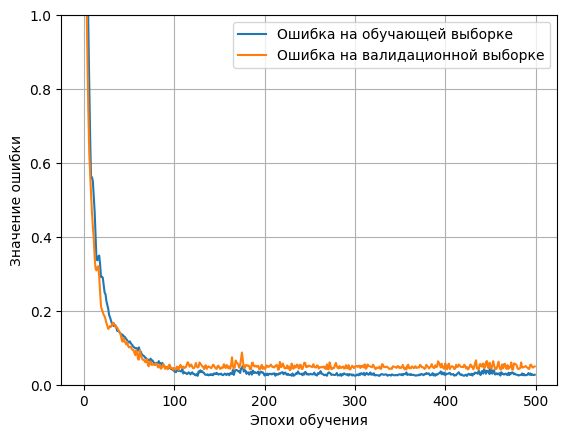

In [35]:
# Строим график обучения
plot_loss(history)

In [36]:
# Делаем предсказания на тестовой выборке
y_pred_w = model_w.predict(test_features_w)

1/1 [==============================] - 0s 47ms/step


In [37]:
# Оцениваем метрику R2
r2_w = r2_score(test_labels_w, y_pred_w)
# Оцениваем метрику MAE
MAE = MeanAbsoluteError()
mae_w = MAE(test_labels_w, y_pred_w).numpy()
# Оцениваем метрику MSE
MSE = MeanSquaredError()
mse_w = MSE(test_labels_w, y_pred_w).numpy()

# Заполняем словари метрик
r2_width['NN'] = round(r2_w, 3)
mae_width['NN'] = round(mae_w, 3)
mse_width['NN'] = round(mse_w, 3)

In [38]:
# Метрики модели
print(f"R2={r2_width['NN']}, MAE={mae_width['NN']}, MSE={mse_width['NN']}")

R2=0.932, MAE=0.3230000138282776, MSE=0.1979999989271164


### 4.4. Сравнение моделей и выбор наилучшей

In [39]:
# Выводим значение метрики R2 для целевой переменной Depth
D_R2 = pd.DataFrame(r2_depth, index=['R2(Depth)']).T
D_R2.sort_values(by='R2(Depth)')

,R2(Depth)
LR,0.615
R,0.617
NN,0.767
RFR,0.855
GBR,0.881
DTR,0.882


In [40]:
# Выводим значение метрики R2 для целевой переменной Width
W_R2 = pd.DataFrame(r2_width, index=['R2(Width)']).T
W_R2.sort_values(by='R2(Width)')

,R2(Width)
NN,0.932
R,0.976
LR,0.977
RFR,0.982
DTR,0.982
GBR,0.983


Для решения поставленной задачи прогнозирования выбираем регрессионную модель DecisionTreeRegressor

## 5. Подбор гиперпараметров и сохранение выбранной модели

In [41]:
# Определим признаки
X = np.array(dataset.iloc[:,0:4])

# Определим целевые перемнные
y_d = np.array(dataset['Depth'])
y_w = np.array(dataset['Width'])

### 5.1. Подбор гиперпараметров и сохранение модели для целевой переменной Depth

In [42]:
# Разбиение на обучающую и тестовую выборки
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X, y_d, test_size=0.2, random_state=42)

In [43]:
# Определяем модель
model_d_dtr = DecisionTreeRegressor()

# Задаем сетку гиперпараметров
param_grid={'min_samples_split': range(2, 10)}

# Производим поиск по сетке
grid_model_d_dtr = GridSearchCV(estimator=model_d_dtr, param_grid=param_grid, cv=2, scoring='r2')
grid_model_d_dtr.fit(X_train_d, y_train_d)

# Выводим лучшие гиперпараметры
print(grid_model_d_dtr.best_estimator_)
print(grid_model_d_dtr.best_score_)
print(grid_model_d_dtr.best_params_)

DecisionTreeRegressor(min_samples_split=6)
0.834914476507619
{'min_samples_split': 6}


In [44]:
# Создаем и обучаем модель с учетом лучших гиперпараметров
model_d_dtr_best = DecisionTreeRegressor(min_samples_split=6)
model_d_dtr_best.fit(X_train_d, y_train_d)
y_pred_d = model_d_dtr_best.predict(X_test_d)

In [45]:
# Считаем метрики
r2 = r2_score(y_test_d, y_pred_d)
mae = mean_absolute_error(y_test_d, y_pred_d)
mse = mean_squared_error(y_test_d, y_pred_d)

# Выводим метрики
print(r2)
print(mae)
print(mse)

0.8817119897370144
0.06481616161616165
0.006869326476890116


In [49]:
# Сохраняем модель
pickle.dump(model_d_dtr_best, open('models/model_d_dtr_best.pkl', 'wb'))

### 5.2. Подбор гиперпараметров и сохранение модели для целевой переменной Width

In [50]:
# Разбиение на обучающую и тестовую выборки
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X, y_w, test_size=0.2, random_state=42)

In [51]:
# Определяем модель
model_w_dtr = DecisionTreeRegressor()

# Задаем сетку гиперпараметров
param_grid={'min_samples_split': range(2, 10)}

# Производим поиск по сетке
grid_model_w_dtr = GridSearchCV(estimator=model_w_dtr, param_grid=param_grid, cv=2, scoring='r2')
grid_model_w_dtr.fit(X_train_w, y_train_w)

# Выводим лучшие гиперпараметры
print(grid_model_w_dtr.best_estimator_)
print(grid_model_w_dtr.best_score_)
print(grid_model_w_dtr.best_params_)

DecisionTreeRegressor()
0.9432185106116007
{'min_samples_split': 2}


In [52]:
# Создаем и обучаем модель с учетом лучших гиперпараметров
model_w_dtr_best = DecisionTreeRegressor(min_samples_split=2)
model_w_dtr_best.fit(X_train_w, y_train_w)
y_pred_w = model_w_dtr_best.predict(X_test_w)

In [53]:
# Считаем метрики
r2 = r2_score(y_test_w, y_pred_w)
mae = mean_absolute_error(y_test_w, y_pred_w)
mse = mean_squared_error(y_test_w, y_pred_w)

# Выводим метрики
print(r2)
print(mae)
print(mse)

0.9822896146221267
0.033963636363636404
0.0017752575451484567


In [54]:
# Сохраняем модель
pickle.dump(model_w_dtr_best, open('models/model_w_dtr_best.pkl', 'wb'))